## 사이킷런을 활용한 MLFlow

In [1]:
# MLFlow 설치
!pip install mlflow

In [2]:
# 활용한 라이브러리 환경
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold

import mlflow
import mlflow.sklearn

print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
print('scikit-learn: {}'.format(sklearn.__version__))
print('MLFlow: {}'.format(mlflow.__version__))

Numpy: 1.20.3
Pandas: 1.3.4
matplotlib: 3.4.3
seaborn: 0.11.2
scikit-learn: 0.24.2
MLFlow: 2.1.1


## 데이터 처리

In [3]:
# 활용한 데이터는 신용카드 부정 탐지 데이터
# data url : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv('creditcard.csv')
df = df.drop('Time', axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# 정상 지점과 이상 징후 분할
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
abnormal = df[df.Class == 1]

print(f"Normal: {normal.shape}")
print(f"Anormaly: {abnormal.shape}")

Normal: (142158, 30)
Anormaly: (492, 30)


In [5]:
# 정상 및 이상 데이터를 train / test/ validation 데이터 셋으로 분할
# train / test/ val = 0.6 / 0.2 / 0.2
normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=2020)
abnormal_train, abnormal_test = train_test_split(abnormal, test_size=0.2, random_state=2020)
normal_train, normal_validate = train_test_split(normal_train, test_size=0.25, random_state=2020)
abnormal_train, abnormal_validate = train_test_split(abnormal_train, test_size=0.25, random_state=2020)

In [6]:
# 데이터 x, y 분할
x_train = pd.concat((normal_train, abnormal_train))
x_test = pd.concat((normal_test, abnormal_test))
x_validate = pd.concat((normal_validate, abnormal_validate))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [7]:
# 데이터셋 확인
print('Train set:\nx_train:{} \ny_train:{}'.format(x_train.shape, y_train.shape))
print('\nTest set:\nx_test:{} \ny_test:{}'.format(x_test.shape, y_test.shape))
print('\nVal set:\nx_train:{} \ny_validate:{}'.format(x_validate.shape, y_validate.shape))

Train set:
x_train:(85588, 29) 
y_train:(85588,)

Test set:
x_test:(28531, 29) 
y_test:(28531,)

Val set:
x_train:(28531, 29) 
y_validate:(28531,)


In [8]:
# 데이터 scale
scaler = StandardScaler()
scaler.fit(pd.concat((normal, abnormal)).drop("Class", axis=1))
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

## MLFlow를 통한 학습 및 평가

In [9]:
# 학습 기능 정의
# 학습 후 정확도 지표를 출력할 수 있도록 정의
def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

In [10]:
# 평가 기능 정의
# 지표를 비교해 AUC 점수가 가장 높은 모델을 선택하도록 평가 함수 정의
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc)    # MLFlow에 AUC Score 로깅
    mlflow.log_metric("auc_score", auc_score)  # MLFlow에 Accuracy 로깅
    print(f"AUC Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    # metric 시각화 및 파일 저장
    roc_plot = plot_roc_curve(sk_model, x_test, y_test, name='scikit-learn ROC Curve')
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

## MLFlow 실행 로깅 및 확인

Train Accuracy: 99.893%
AUC Score: 85.341%
Eval Accuracy: 99.874%


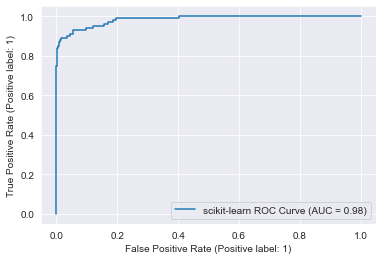

Model run:  85a4a757025f4d4e9b45fb91062b61ef


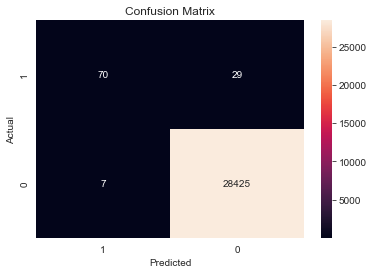

In [11]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg')
mlflow.set_experiment("scikit_learn_experiment")  # MLFlow 실험 이름 정의
with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [17]:
# powershell에서 mlflow ui -p 1234 입력
# 만약 ImportError: cannot import name 'escape' from 'jinja2' (C:\Users\jyshin\anaconda3\lib\site-packages\jinja2\__init__.py) 에러 날 경우 pip install jinja2==3.0.3

## 로깅된 모델 적재

In [20]:
loaded_model = mlflow.sklearn.load_model("runs:/bdfd5bcf28a64516bffd40a06bb5b2e8/log_reg_model")

In [21]:
# 저장한 모델을 가지고 바로 score를 확인할 수 있음
loaded_model.score(x_test, y_test)

0.9987382145736217

## API 서빙

In [28]:
import mlflow
logged_model = 'runs:/bdfd5bcf28a64516bffd40a06bb5b2e8/log_reg_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
data = x_test
print(data)
print(loaded_model.predict(pd.DataFrame(data)))

[[-1.17362921  1.31797632 -0.73359473 ...  1.20727226  0.99802045
  -0.32742236]
 [-0.39215527  0.6299131   0.79925401 ... -0.06476623  0.15898721
  -0.33791875]
 [ 0.01896693 -0.38831066  0.30187387 ...  0.44082095  0.40919241
  -0.18358291]
 ...
 [ 0.94148201  0.64426556 -1.11897491 ...  0.10419496  0.1215325
  -0.34297257]
 [-0.76080487  0.6827188  -1.00780021 ...  1.01108636  0.81108554
   0.88980931]
 [-5.20609906  3.92012265 -9.5660635  ... -1.1412922   0.32030633
  -0.34297257]]
[0 0 0 ... 0 1 1]


In [12]:
# API Serving 명령어(터미널 창) : mlflow models serve --model-uri runs:/bdfd5bcf28a64516bffd40a06bb5b2e8/log_reg_model -p 1235

In [14]:
!pip freeze > requirements.txt